In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.14.0


## 1. Data Exploration: Inspecting the MNIST Dataset

In [2]:
# Importing the MNIST dataset from keras
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
# Inspecting shapes
print('X Train: {}'.format(x_train.shape))
print('X Test:  {}'.format(x_test.shape))
print('Y Train: {}'.format(y_train.shape))
print('X Test:  {}'.format(y_test.shape))

X Train: (60000, 28, 28)
X Test:  (10000, 28, 28)
Y Train: (60000,)
X Test:  (10000,)


In [4]:
# Inspecting min and max
print('X Train min {} max {}'.format(x_train.min(), x_train.max()))
print('X Test  min {} max {}'.format(x_test.min(), x_test.max()))
print('Y Train min {} max {}'.format(y_train.min(), y_train.max()))
print('Y Test  min {} max {}'.format(y_test.min(), y_test.max()))

X Train min 0 max 255
X Test  min 0 max 255
Y Train min 0 max 9
Y Test  min 0 max 9


In [5]:
# Inspecting class label distribution/skewness
import numpy as np
import pandas as pd

print('NumPy', np.__version__)
print('Pandas', pd.__version__)

classes, counts = np.unique(y_train, return_counts=True)
class_fd_train = dict(zip(classes, counts * 100 / y_train.shape[0]))
classes, counts = np.unique(y_test, return_counts=True)
class_fd_test = dict(zip(classes, counts * 100 / y_test.shape[0]))

if class_fd_test.keys() == class_fd_train.keys():
    print('\nAll classes present in both: True', end='\n\n')
    class_dist = {'train': [], 'test': []}
    classes.sort()
    for class_label in classes:
        class_dist['train'].append(class_fd_train[class_label])
        class_dist['test'].append(class_fd_test[class_label])
    class_dist = pd.DataFrame(class_dist, index=classes)
    print(class_dist)
else:
    print('All classes present in both: False')

NumPy 1.17.2
Pandas 0.23.4

All classes present in both: True

       train   test
0   9.871667   9.80
1  11.236667  11.35
2   9.930000  10.32
3  10.218333  10.10
4   9.736667   9.82
5   9.035000   8.92
6   9.863333   9.58
7  10.441667  10.28
8   9.751667   9.74
9   9.915000  10.09


3.0.2


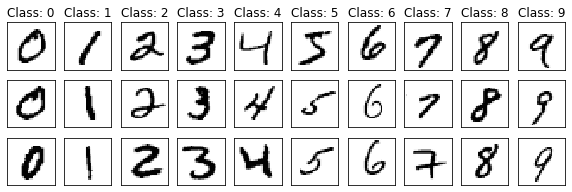

In [6]:
# Showing sample x_train images
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print(matplotlib.__version__)

n_rows = 3
fig, axs = plt.subplots(nrows=n_rows,
                        ncols=len(classes), figsize=[10, n_rows])

for col, class_label in enumerate(classes):
    sample = np.where(y_train == class_label)[0]
    for row in range(n_rows):
        axs[row, col].imshow(x_train[sample[row]], cmap=plt.cm.Greys)
        axs[row, col].axes.get_xaxis().set_visible(False)
        axs[row, col].axes.get_yaxis().set_visible(False)
        if row == 0:  # Show label on the title for first row only
            axs[row, col].set_title('Class: {}'.format(class_label))

plt.show()

### Data Exploration Conlusions:
1. 60k training and 10k testing samples
2. X samples are 28x28 binary images of handwritten numbers
3. Y samples are the labels for the handrwitten numbers and range between 0 to 9
4. 784 numerical features ranging between 0 and 255
5. 10 classes (0 through 9) that are equally distributed 
6. Multi-Class Classification Problem

## 2. Preprocessing: Scaling
Neural Networks accuracy is significantly improved when the input features are scaled. There are primarily two methods for scaling numerical data:
* **Normalization**: scaling between 0 and 1
* **Standardization**: scaling to obtain mean of 0 and standard deviation of 1

We will be normalizing our data.

In [7]:
# Normalizing feature sets
x_train_scaled = tf.keras.utils.normalize(x_train, axis=1)
x_test_scaled = tf.keras.utils.normalize(x_test, axis=1)

# Inspecting min and max
print('X Train min {} max {}'.format(x_train_scaled.min(),
                                     x_train_scaled.max()))
print('X Test  min {} max {}'.format(x_test_scaled.min(),
                                     x_test_scaled.max()))

X Train min 0.0 max 1.0
X Test  min 0.0 max 1.0


## 3. The Model

### 3.1 Model Architecture
Every Artificial Neural Network model has the following layers:
1. **Input Layer**: Single layer that takes the model inputs and flattens the input data if it comes in the form of a multi-dimentional matrix.
    * Number of nodes same as number of input features


2. **Hidden Layer**: All the layers between the input and the output layer.    
    * Number of nodes (called *units* in TensorFlow) is a design parameter
    * Number of hidden layers is a design parameter


3. **Output Layer**: Single layer that the output is spat out at.
    * Number of nodes depends on what kind of task the model is being trained for (Regression or Classification). The regression case is straight forward, the number of nodes is same as the number of numbers to predict and for Classification it depends but typically it is best to have as many as the number of class labels as that would yield confidence values for each class


For our model we will have an input layer that will faltten the binary images (means 784 nodes) and then 2 fully-connected hidden layers, each with 128 nodes or *units*, followed bu the output layer which will be also a fully-connected layer with 10 nodes as we have 10 class labels.

### 3.2 Defining The Layers
We will be using 2 types of layers (there are **many** available to chose from in TensorFlow):
1. `Flatten`: flattens a multidimentional array (e.g. 28x28 --> 1x784)

2. `Dense`: fully-connected layer with the following *main* parameters:
    * **units**: number of nods in the layer
    * **activation**: the activation function of the nodes
        - There are again **many** types of actication functions in TensorFlow but we will stick to the following:
            - `relu`: Rectified linear for all hidden layers
            - `softmax`: to generate a probability distribution at the output layer


### 3.3 Training the model
There are 4 important parameters that control model training:
* **Optimizer**: The optimization algorithm used during back-propagation
* **Loss**: The loss metric to minimize
* **Epochs**: Number of times the model trains over the entire data set

In [8]:
# Model Architecture
model = tf.keras.models.Sequential([

    # Input layer
    tf.keras.layers.Flatten(input_shape=(28, 28)),

    # Hidden layers
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    # Output layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),

])

# Compiling the model
model.compile(
    optimizer='adam',  # One of the best opt algos
    loss='sparse_categorical_crossentropy',  # Commonly used for clfs
    metrics=['accuracy']  # This is the metric being watched **only**
)

# Training
model.fit(x_train_scaled, y_train, epochs=3)

# Testing
loss, accuracy = model.evaluate(x_test_scaled, y_test)

print('Loss:     {}'.format(loss))
print('Accuracy: {}'.format(accuracy))

Epoch 1/3
60000/60000 [==============================] - 2s 30us/sample - loss: 0.2654 - acc: 0.9228
Epoch 2/3
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1123 - acc: 0.9651
Epoch 3/3
10000/10000 [==============================] - 0s 15us/sample - loss: 0.0941 - acc: 0.9699
Loss:     0.09412358136596158
Accuracy: 0.9699000120162964


### Saving and loading a model

In [9]:
model.save('data/models/MNIST_v1.model')

In [10]:
loaded_model = tf.keras.models.load_model('data/models/MNIST_v1.model')

### Predicting with a loaded model

In [11]:
# Getting raw predictions
pred = loaded_model.predict(x_test_scaled)
print('Pred Raw:   ', pred.shape)

# Getting argmax of each row to get class label with best score
predictions = np.argmax(pred, axis=1)
print('Pred Argmax:', predictions.shape, end='\n\n')

# Correct predictions
correct = np.equal(predictions, y_test)

# Creating dataframe
pred = pd.DataFrame(pred, columns=range(10))
predictions = pd.DataFrame({'pred': predictions, 'correct': correct})
pred = pd.concat([pred, predictions], axis=1)

# First 5 test samples
print(pred.head())

Pred Raw:    (10000, 10)
Pred Argmax: (10000,)

              0             1             2             3             4  \
0  3.165697e-08  4.221981e-07  8.904408e-06  8.042196e-05  1.027812e-09   
1  1.553164e-07  5.873868e-05  9.997144e-01  1.868432e-04  2.275137e-09   
2  4.144831e-08  9.998747e-01  8.275867e-06  6.227418e-06  4.341443e-06   
3  9.997724e-01  2.994624e-07  1.256942e-05  8.895321e-07  2.575425e-06   
4  8.542951e-08  3.994572e-08  7.810487e-07  1.120714e-07  9.996219e-01   

              5             6             7             8             9  pred  \
0  1.431809e-09  8.874992e-13  9.999098e-01  3.331815e-08  4.298265e-07     7   
1  6.885416e-08  3.502012e-07  3.089832e-08  3.937167e-05  1.809567e-10     2   
2  1.045552e-07  1.144854e-06  3.533137e-05  6.991196e-05  3.495114e-08     1   
3  3.767867e-07  3.723729e-05  1.282651e-04  2.545352e-06  4.307285e-05     0   
4  6.757273e-07  5.214998e-07  3.697682e-06  6.344563e-06  3.658466e-04     4   

   correct  
0

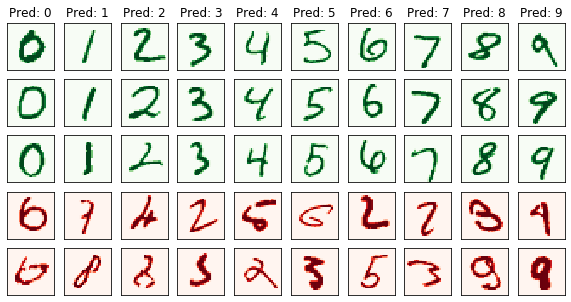

In [12]:
n_rows = 5  # Minimum 3
fig, axs = plt.subplots(nrows=n_rows,
                        ncols=len(classes), figsize=[10, n_rows])

for col, class_label in enumerate(classes):
    sample = pred[pred['pred'] == class_label]
    c = sample[sample['correct'] == True].iloc[:n_rows - 2, :]
    n = sample[sample['correct'] == False].iloc[:2, :]
    sample = pd.concat([c, n], axis=0)
    for row in range(n_rows):
        correct = sample.loc[sample.index[row], 'correct']
        img = x_test[sample.index[row]]
        if correct:
            axs[row, col].imshow(img, cmap=plt.cm.Greens)
        else:
            axs[row, col].imshow(img, cmap=plt.cm.Reds)
        axs[row, col].axes.get_xaxis().set_visible(False)
        axs[row, col].axes.get_yaxis().set_visible(False)
        if row == 0:
            axs[row, col].set_title('Pred: {}'.format(class_label))

plt.show()